# 2.34 Creating a Custom Multi Layer Design

### NOTE: Simulation of Multi Layer devices are only supported by QElmer and QPalace (soon to be implemented)

As Qiskit Metal moves towards open-source renderers, we should start rendering & simulating our devices in 3D. This will give better agreement between simulation and reality.

This shows how to make 3D devices, where the $z$ axis is discretized.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

# 1 Create  `designs.MultiPlanar()`
Previously, we've placed `QComponents` on `designs.DesignPlanar` canvas, this would lead to 2D designs. Now let's create a canvas which supports 3D designs.

In [3]:
design = designs.MultiPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)

In [4]:
print(type(design.ls))
design.ls.ls_df

<class 'qiskit_metal.toolbox_metal.layer_stack_handler.LayerStackHandler'>


,chip_name,layer,datatype,material,thickness,z_coord,fill
0,main,1,0,pec,2um,0um,true
1,main,3,0,silicon,-750um,0um,true


You may have noticed, we have a new attribute called `LayerStackHandler`. This gives the canvas 3D capabilities.

- `chip_name` (str): References which chip we're drawing on.
- `layer` (int): This is the number you'll reference in `QComponent.options.layer`, this tells the QComponent to go into that layer.
- `datatype` (int): ??? (if you know, send a PR)
- `material` (str): Type of material, self explanatory. 
- `thickness` (str): References direction of thickness, can be positive or negative.
- `z_coord` (str): Origin of thickness.

**For the Example Above:**
- Layer 1 currently occupies $z \in [0um, 2um]$
- Layer 3 currenlty occupies $z \in [-750um, 0um]$

## Let's add/edit the layers

In [5]:
new_layer1 = {'chip_name': 'main',
             'layer': 2,
             'datatype': 0,
             'material': 'pec',
             'thickness': '2um',
             'z_coord': '52um',
             'fill' : True}
new_layer2 = [{'chip_name': 'main',
              'layer':4,
              'datatype': 0,
              'material': 'pec',
              'thickness': '50um', # note: these are one the same positon
              'z_coord': '2um', # this allowed!
              'fill': True},
              {'chip_name': 'main',
              'layer':5,
              'datatype': 0,
              'material': 'silicon',
              'thickness': '50um', # note: these are one the same positon
              'z_coord': '2um', # this allowed!
              'fill': True}]

design.ls.ls_df = design.ls.ls_df.append(new_layer1, ignore_index=True)
design.ls.ls_df = design.ls.ls_df.append(new_layer2, ignore_index=True)
design.ls.ls_df

,chip_name,layer,datatype,material,thickness,z_coord,fill
0,main,1,0,pec,2um,0um,true
1,main,3,0,silicon,-750um,0um,true
2,main,2,0,pec,2um,52um,True
3,main,4,0,pec,50um,2um,True
4,main,5,0,silicon,50um,2um,True


Now we have a few more layers.
- Layer 1 (Transmon Layer): $z \in [0,2um]$
- Layer 2 (CPW Layer): $z \in [52um, 54um]$
- Layer 3 (Metal layer): $z \in [-750um, 0um]$
- Layer 4 (Connection between Transmon and CPW): $z \in [2um, 52um]$
- Layer 5 (Connection between Transmon and CPW): $z \in [2um, 52um]$

Of course, you don't have to use these exact thicknesses and ordering. That's up to you.

# Let's Draw a Transmon in Layer 1

The real world, we deposit PEC onto our silicon. Hence, we should build our Transmon onto the raised layer.

In this case, layer 1 refers to the `pec` with 2um thickness at $z=0 \, um$.

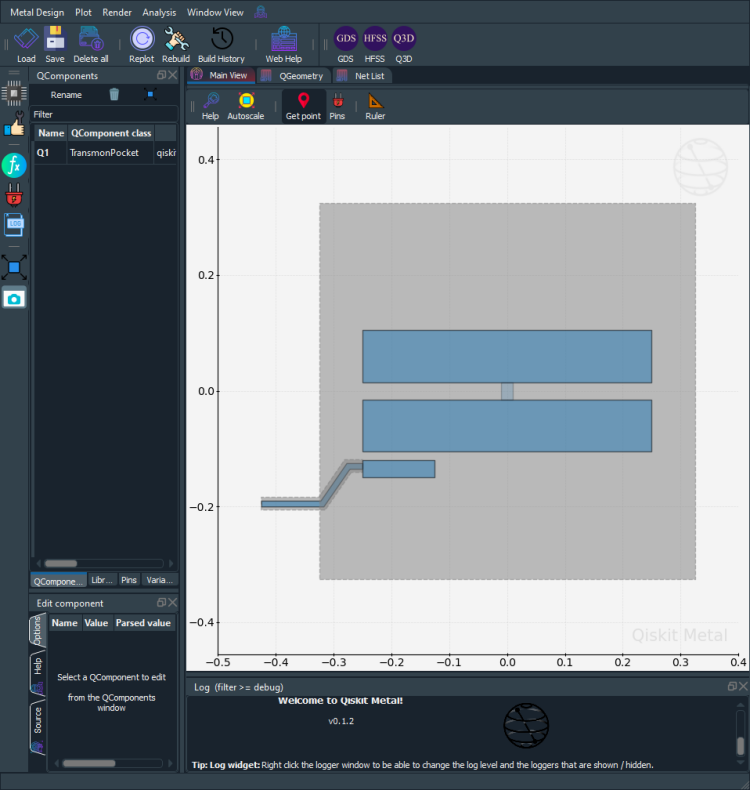

In [6]:
design.delete_all_components()

q1_options = dict(pad_width = '500um', 
                  connection_pads = dict(readout = dict(loc_W = -1, loc_H = -1)),
                  layer = 1)  # THIS IS WHERE YOU DECLARE LAYER NUMBER
                              # Note how we'll change this in every design

q1 = TransmonPocket(design, "Q1", options=q1_options)

gui.rebuild()
gui.zoom_on_components(['Q1'])
gui.screenshot()

# Let's Draw a "connection pole" from $z = [0um, 54um]$

In this design, our Transmon and CPW will be on different layers. To get them to talk to eachother, we need a "connection pole"... Something to transverse the layers.

I am uncertain of the terminology so please submit a PR and correct me, but I'm going to be calling a vertical CPW a "pole". 

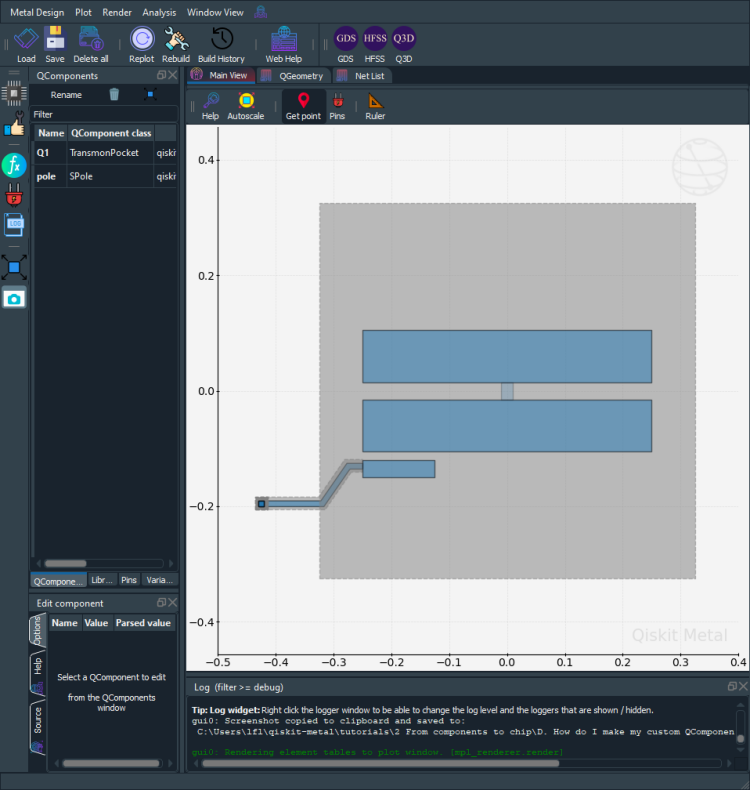

In [7]:
from qiskit_metal.qlibrary.tlines.square_pole import SPole

sp = SPole(design, 'pole', options=dict(layers=[1,2,4,5],
                                   name = 'Q1', # Which component
                                   pin = 'readout')) # and pin to attach to

gui.rebuild()
gui.zoom_on_components(['Q1', 'pole'])
gui.screenshot()

# Let's Draw a CPW in Layer 2

In [8]:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [11]:
otg_pole_options = Dict(pos_x = sp.options.pos_x,
                        pos_y = sp.options.pos_y,
                        orientation = 0,
                        layer = 2)

otg2_options = Dict(pos_x = '-1.5mm',
                    pos_y = 0,
                    orientation = 180,
                    layer = 2)


otg_pole = OpenToGround(design, 'otg_pole', options=otg_pole_options)
otg2 = OpenToGround(design, 'otg2', options=otg2_options)

09:16AM 17s WARNING [check_lengths]: For path table, component=meander, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:16AM 17s WARNING [check_lengths]: For path table, component=meander, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:16AM 18s WARNING [check_lengths]: For path table, component=meander, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:16AM 18s WARNING [check_lengths]: For path table, component=meander, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.


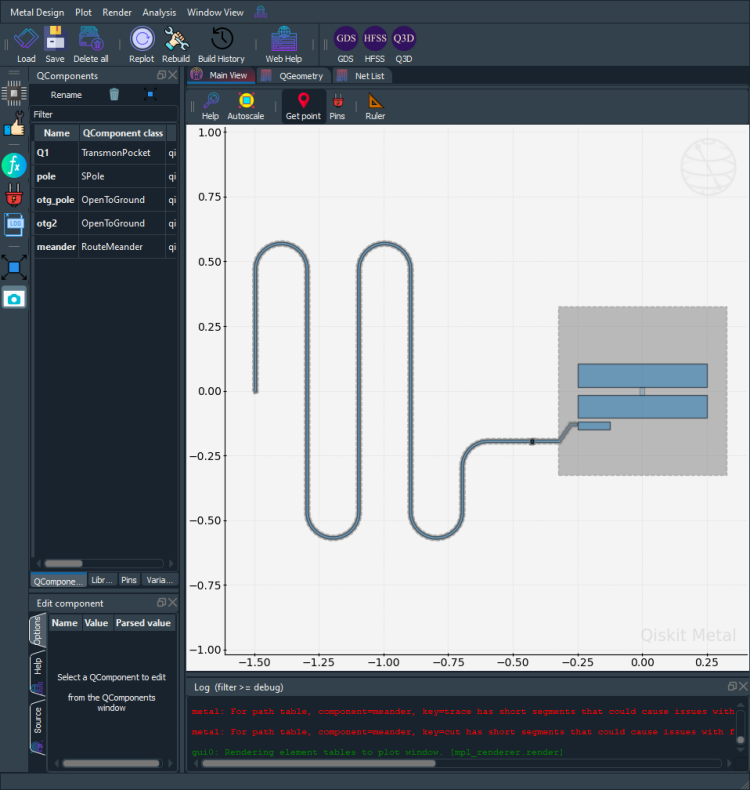

In [12]:
meander_options = Dict(pin_inputs=Dict(start_pin=Dict(component='otg2',
                                                      pin='open'),
                                       end_pin  =Dict(component='otg_pole',
                                                      pin='open')),
                      total_length = '5mm',
                      fillet='99.99um',
                      layer = 2)

meander = RouteMeander(design, 'meander', options=meander_options)

gui.rebuild()
gui.zoom_on_components(['meander', 'Q1'])
gui.screenshot()